# GWAS-GRPM Merger

This notebook enables the integration of the GWAS catalog dataset into the existing GRPM dataset. It begins by retrieving the GRPM Survey data and applying a Gene Interest (GI) cut-off, which is used to prioritize relevant genes. Next, an alignment process merges the filtered GRPM Survey and the GWAS dataset based on their shared rsIDs (reference SNP id numbers). 

Allignment between GWAS traits and MeSH terms is achieved by semantic similarity calculated by text embedding based on the BioBERT language model (GPU required)

An earlier version of the module employed a simple NLP-based method (deprecated):
This method uses a correspondence dictionary and the Natural Language Toolkit (NLTK) to align the MeSH terms from GRPM with the GWAS-mapped traits. Lastly, for each rsID, the strongest SNP-risk allele is identified using the correspondence dictionary. This integrated data serves as a preliminary indicator of potential effect alleles and can be useful for further in-silico or clinical studies based on the identified associations.

In [3]:
#Only for Google Colab
import os
import sys
import subprocess

# @markdown Run in Colab virtual machine by default

# @markdown to run in google drive set:
import_mydrive = False #@param {type:"boolean"}


if 'google.colab' in sys.modules:
    subprocess.run(["pip", "install", "nbib"])
    subprocess.run(["pip", "install", "biopython"])

    if import_mydrive:
        from google.colab import drive
        drive.mount('/content/drive')

        if not os.path.exists('/content/drive/MyDrive/grpm_system/'):
            subprocess.run(['mkdir', '/content/drive/MyDrive/grpm_system/'])
        subprocess.run(['cd', '/content/drive/MyDrive/grpm_system/'])
    else:
        if not os.path.exists('/content/grpm_system/'):
            subprocess.run(['mkdir', '/content/grpm_system/'])
        subprocess.run(['cd', '/content/grpm_system/'])

current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: G:\Altri computer\Horizon\horizon_workspace\projects\work\semantics\GRPM\GRPM_github


# Import Packages

In [5]:
import os
import io
import sys
import glob
import gdown
import zipfile
import requests
import pyarrow
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
if not 'google.colab' in sys.modules:
    import pyperclip as pc

def simple_bool(message):
    choose = input(message+" (y/n): ").lower()
    your_bool = choose in ["y", "yes","yea","sure"]
    return your_bool

def get_file(url, file_name, dir = os.getcwd()):
    url = url
    file_name = file_name
    response = requests.get(url)
    if response.status_code == 200:
        content = response.content
        file_path = os.path.join(dir, file_name)
        with open(file_path, 'wb') as file:
            file.write(content)


def get_gitfile(url, flag='', dir = os.getcwd()):
    url = url.replace('blob','raw')
    response = requests.get(url)
    file_name = flag + url.rsplit('/',1)[1]
    file_path = os.path.join(dir, file_name)
    if response.status_code == 200:
        with open(file_path, 'wb') as file:
            file.write(response.content)
        print(f"File downloaded successfully. Saved as {file_name}")
    else:
        print("Unable to download the file.")

releases = {'0.1':'8205724',
            '0.2':'14052302'}

def get_from_zenodo(file, record_id=releases['0.2'], dir=os.getcwd()): # 14052302
    # Construct the download URL
    url = f'https://zenodo.org/record/{record_id}/files/{file}?download=1'
    print(f'Downloading {file} from {url}')
    extracted_folder_name = dir
    # Define the output path for the file
    output_path = os.path.join(extracted_folder_name, file)
    # Use gdown to download the file
    gdown.download(url, output_path, quiet=False)
    return output_path

def get_and_extract(file, record_id=releases['0.2'], dir=os.getcwd(), ext='.zip', remove_zip=True):
    zip_file_name = file + ext
    extracted_folder_name = dir
    # Download the ZIP file using get_from_zenodo
    zip_file_path = get_from_zenodo(file + ext, record_id, dir)
    # Extract the ZIP contents
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        print('Extracting...')
        zip_ref.extractall(extracted_folder_name)
    print(f"ZIP file '{zip_file_name}' extracted in '{extracted_folder_name}' successfully.")
    # Remove the ZIP file after extraction
    if remove_zip: os.remove(zip_file_path)


##### Specific Functions ####
def grpm_importer():
    time2 = datetime.now()
    grpm_dataset = pd.read_parquet('grpm_dataset//grpm_dataset.parquet', engine='pyarrow')
    print('Importing time: ',datetime.now() - time2)

    pcg_grpm    = grpm_dataset[grpm_dataset.type == 'PCG'].reset_index(drop=True)
    rna_grpm    = grpm_dataset[grpm_dataset.type == 'RNA'].reset_index(drop=True)
    pseudo_grpm = grpm_dataset[grpm_dataset.type == 'PSD'].reset_index(drop=True)
    #pcg_grpm = pd.read_parquet('grpm_dataset/grpm_db_pcg/grpm_dataset.parquet', engine = 'pyarrow')
    def printer(df, tag):
        print(tag,   round(df.memory_usage().sum()    / 1024 / 1024, 2), 'MB')
    printer(pcg_grpm, 'pcg:')
    printer(rna_grpm, 'rna:')
    printer(pseudo_grpm, 'pseudo:')
    return pcg_grpm, rna_grpm, pseudo_grpm

def nutrig_importer():
    grpm_nutrigen = pd.read_parquet('nutrigenetic_dataset/grpm_nutrigen.parquet')
    grpm_nutrigen_int = pd.read_parquet('nutrigenetic_dataset/grpm_nutrigen_int.parquet')
    gwas_path = 'nutrigenetic_dataset/grpm_nutrigen_int_gwas.parquet'
    is_gwas = os.path.exists(gwas_path)
    grpm_nutrigen_int_gwas = pd.read_parquet(gwas_path) if is_gwas else pd.DataFrame()
    def printer(df, tag):
        print(tag,   round(df.memory_usage().sum()    / 1024 / 1024, 2), 'MB')
    printer(grpm_nutrigen, 'nutrigen dataset:')
    printer(grpm_nutrigen_int, 'nutrigen dataset filtered:')
    printer(grpm_nutrigen_int_gwas, 'nutrigen gwas dataset:')

    return   grpm_nutrigen, grpm_nutrigen_int, grpm_nutrigen_int_gwas

In [1]:


def check_and_install_module(module_name):
    try:
        # Check if the module is already installed
        importlib.import_module(module_name)
        print(f"The module '{module_name}' is already installed.")
    except ImportError:
        # If the module is not installed, try installing it
        x = simple_bool(
            "\n" + module_name + "  module is not installed.\nwould you like to install it?")
        if x:
            import subprocess
            subprocess.check_call(["pip", "install", module_name])
            print(f"The module '{module_name}' was installed correctly.")
        else:
            pass

# Check 'SentenceTransformer'
check_and_install_module('sentence_transformers')
from sentence_transformers import SentenceTransformer

## Check 'NLTK'
# get Natural Language Toolkit https://www.nltk.org/
check_and_install_module('nltk')
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

The module 'sentence_transformers' is already installed.
The module 'nltk' is already installed.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Utente\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Utente\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Get requirements

Get GRPM Data

In [6]:
# Get GRPM Dataset from Zenodo Repository
#https://zenodo.org/record/8205724  DOI: 10.5281/zenodo.8205724

if not os.path.exists('nutrigenetic_dataset/grpm_nutrigen.parquet'):
    timea = datetime.now()
    get_and_extract('nutrigenetic_dataset')
    print('Download and extraction time ',datetime.now()-timea)

Downloading...
From: https://zenodo.org/record/14052302/files/nutrigenetic_dataset.zip?download=1
To: G:\Altri computer\Horizon\horizon_workspace\projects\work\semantics\GRPM\GRPM_github\nutrigenetic_dataset.zip
100%|██████████| 16.6M/16.6M [00:05<00:00, 3.07MB/s]


Extracting...
ZIP file 'nutrigenetic_dataset.zip' extracted in 'G:\Altri computer\Horizon\horizon_workspace\projects\work\semantics\GRPM\GRPM_github' successfully.
Download and extraction time  0:00:06.809880


Get MESH.csv from 'bioportal.bioontology.org'

In [5]:
%%time
# Get GWAS dataset at https://www.ebi.ac.uk/gwas/docs/file-downloads

if not os.path.exists('gwas_data'):
    os.makedirs('gwas_data')

if not os.path.exists('gwas_data/gwas_catalog_v1.0.2-associations_e109_r2023-03-27.tsv'):
    get_file( url='https://www.ebi.ac.uk/gwas/api/search/downloads/alternative', file_name='gwas_catalog_v1.0.2-associations.tsv', dir = 'gwas_data')

Workflow:

1. Clean GWAS dataset
   (in STRONGEST SNP-RISK ALLEL, drop "?")
2. retrieve GRPM Survey data
3. apply GI cut-off (0.0125) on GRPM Survey
4. merge GWAS and GRPM on rsIDs
5. align GRPM-MESH vs GWAS-mapped-trait
6.  creating corrispondence dictionary
    ['PUBMED_MESH','DISEASE/TRAIT']
    through Tokenization -> Natural Language Toolkit https://www.nltk.org/
7. get the STRONGEST SNP-RISK ALLELE


# 1. Import GWAS dataset

In [ ]:
%%time
#import dataset
# Download gwas_catalog_v1.0.2-associations_e109_r2023-03-27.tsv from: https://www.ebi.ac.uk/gwas/docs/file-downloads

df_gwas = pd.read_table('gwas_data/gwas_catalog_v1.0.2-associations.tsv', low_memory=False)
df_gwas[['PUBMEDID','SNP_ID_CURRENT']] = df_gwas[['PUBMEDID','SNP_ID_CURRENT']].astype(str)

df_gwas['MAPPED_GENE'] = df_gwas['MAPPED_GENE'].astype(str)  # Convert MAPPED_GENE column to string type
clean_df_gwas = df_gwas[~df_gwas['MAPPED_GENE'].str.contains('- |,')] # drop readthough transcripts

print('MAPPED_GENE: ', clean_df_gwas['MAPPED_GENE'].nunique())
print('STUDY: ', len(df_gwas['STUDY'].drop_duplicates()))
print('SNP_ID: ', len(df_gwas['SNP_ID_CURRENT'].drop_duplicates()))
print('SNPs:',         df_gwas.SNPS            .nunique())
print('DISEASE/TRAIT:',df_gwas['DISEASE/TRAIT'].nunique())
print('MAPPED_TRAIT:', df_gwas['MAPPED_TRAIT'] .nunique())

print(df_gwas.columns)
df_gwas[['MAPPED_GENE','DISEASE/TRAIT','MAPPED_TRAIT','SNP_ID_CURRENT','STRONGEST SNP-RISK ALLELE','RISK ALLELE FREQUENCY']].drop_duplicates()

In [4]:
df_gwas['MAPPED_TRAIT'].value_counts()#.to_csv('MAPPED_TRAIT_value_count.csv')

MAPPED_TRAIT
body height                                                             27453
blood protein measurement                                               16760
body mass index                                                         15537
high density lipoprotein cholesterol measurement                         8536
triglyceride measurement                                                 8008
                                                                        ...  
viral subtype carrier status                                                1
10-nonadecenoate 19:1n9 measurement                                         1
pyelonephritis                                                              1
level of bromodomain-containing protein 2 in blood serum                    1
trait in response to traditional medicine, drug-induced liver injury        1
Name: count, Length: 11467, dtype: int64

# 2. Preprocess GWAS dataset (required)

In [2]:
import pyarrow
data_path = 'gwas_data/gwas_catalog_processed.parquet'
if not data_path:
    choose_df = clean_df_gwas # or full df_gwas
    
    # Drop non risk/effect allele:
    mask = df_gwas['STRONGEST SNP-RISK ALLELE'].str.contains("\?")
    df_gwas_drop = choose_df[-mask].reset_index(drop=True)
    
    # Drop complementary base allele (risk allele freq missing)
    df_gwas_drop_nonan = df_gwas_drop.dropna(subset=['RISK ALLELE FREQUENCY'],axis=0).reset_index(drop=True)
    df_gwas_drop_nonan.to_parquet(data_path, engine= 'pyarrow', index=False)
    df_gwas_ = df_gwas_drop_nonan
else:
    df_gwas_drop_nonan = pd.read_parquet(data_path, engine= 'pyarrow')
    df_gwas_ = df_gwas_drop_nonan
    
print('Drop no risk allele:')
print('SNPs:',len(df_gwas_drop_nonan.SNPS.drop_duplicates()))
print('DISEASE/TRAIT:',len(df_gwas_drop_nonan['DISEASE/TRAIT'].drop_duplicates()))
print('MAPPED_TRAIT:',len(df_gwas_drop_nonan['MAPPED_TRAIT'].drop_duplicates()))

Drop no risk allele:
SNPs: 142639
DISEASE/TRAIT: 22140
MAPPED_TRAIT: 7927


In [4]:
df_gwas_.columns

Index(['DATE ADDED TO CATALOG', 'PUBMEDID', 'FIRST AUTHOR', 'DATE', 'JOURNAL',
       'LINK', 'STUDY', 'DISEASE/TRAIT', 'INITIAL SAMPLE SIZE',
       'REPLICATION SAMPLE SIZE', 'REGION', 'CHR_ID', 'CHR_POS',
       'REPORTED GENE(S)', 'MAPPED_GENE', 'UPSTREAM_GENE_ID',
       'DOWNSTREAM_GENE_ID', 'SNP_GENE_IDS', 'UPSTREAM_GENE_DISTANCE',
       'DOWNSTREAM_GENE_DISTANCE', 'STRONGEST SNP-RISK ALLELE', 'SNPS',
       'MERGED', 'SNP_ID_CURRENT', 'CONTEXT', 'INTERGENIC',
       'RISK ALLELE FREQUENCY', 'P-VALUE', 'PVALUE_MLOG', 'P-VALUE (TEXT)',
       'OR or BETA', '95% CI (TEXT)', 'PLATFORM [SNPS PASSING QC]', 'CNV',
       'MAPPED_TRAIT', 'MAPPED_TRAIT_URI', 'STUDY ACCESSION',
       'GENOTYPING TECHNOLOGY'],
      dtype='object')

Full dataset:
SNPs: 267372
DISEASE/TRAIT: 21399
MAPPED_TRAIT: 7690

# 3. Merge GWAS and Nutrigen-GRPM

## BioBERT Semantic Alignment 

### I. Load Nutrigen GRPM 

In [9]:
grpm_nutrigen_int = pd.read_parquet('grpm_nutrigen_int.parquet')
grpm_meshs = grpm_nutrigen_int.mesh.drop_duplicates()
grpm_nutrigen_int.head(5)
grpm_meshs

0                    Body Mass Index
1          Diabetes Mellitus, Type 2
2                               Diet
4            Cardiovascular Diseases
5                            Obesity
                     ...            
1161146         Conjugation, Genetic
1163895    Absorption, Physiological
1166849       Ketone Oxidoreductases
1169431        Mucociliary Clearance
1169774            Liver Circulation
Name: mesh, Length: 1486, dtype: object

### II. Get embeddings

In [206]:
from sentence_transformers import SentenceTransformer

# Choose embedding model
language_model = 'dmis-lab/biobert-v1.1'
sentence_transformer = SentenceTransformer(language_model)

def extract_embedding(input_text):
    # Encode the input text to get the embedding
    embedding = sentence_transformer.encode(input_text, show_progress_bar=True)
    return embedding

# Get MeSH embeddings
grpm_meshs = grpm_meshs.reset_index(drop=True)
mesh_embeddings = extract_embedding(grpm_meshs.to_list())
len(mesh_embeddings)

No sentence-transformers model found with name C:\Users\Utente/.cache\torch\sentence_transformers\dmis-lab_biobert-v1.1. Creating a new one with MEAN pooling.


Batches:   0%|          | 0/47 [00:00<?, ?it/s]

In [26]:
# get GWAS embeddings
gwas_traits = df_gwas_['DISEASE/TRAIT'].drop_duplicates()
gwas_traits = gwas_traits.reset_index(drop=True)
gwas_embedding = extract_embedding(gwas_traits.to_list())
len(gwas_embedding)

Batches:   0%|          | 0/692 [00:00<?, ?it/s]

0                                           Prostate cancer
17          Attention deficit hyperactivity disorder (MTAG)
22                          Autism spectrum disorder (MTAG)
26                                  Bipolar disorder (MTAG)
27        Sex hormone-binding globulin levels adjusted f...
                                ...                        
285582                   DTI TBSS L1 Cingulum hippocampus R
285641                                   Neutral fat levels
285654                                      Globulin levels
285655                               Albumin-globulin ratio
285657                      High-density lipoprotein levels
Name: DISEASE/TRAIT, Length: 22140, dtype: object

### III. Build the GWAS-MESH correspondence table.

In [208]:
%%time
import numpy as np
import pandas as pd
from tqdm import tqdm

array2 = mesh_embeddings#[:100]
array1 =  gwas_embedding#[:100]

# Function to compute cosine similarity
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

# Calculate the cosine similarities
similarities = np.zeros((array1.shape[0], array2.shape[0]))
for i in tqdm(range(array1.shape[0])):
    for j in range(array2.shape[0]):
        similarities[i, j] = cosine_similarity(array1[i], array2[j])

# Create a DataFrame with the similarities
similarities_df = pd.DataFrame(similarities, index=[i for i in range(array1.shape[0])],
                               columns=[j for j in range(array2.shape[0])])

# Find the index of the maximum value in each row
max_indices = similarities_df.idxmax(axis=1)
# Find the maximum value in each row
max_values = similarities_df.max(axis=1)

# Create a DataFrame with the correspondence between row index and column values
correspondence_table_gwas_mesh = pd.DataFrame({
    "gwas_id": max_indices.index,
    "mesh_id": max_indices.values,
    "Max Value": max_values.values
})
print(correspondence_table_gwas_mesh)

100%|██████████| 22140/22140 [05:16<00:00, 69.89it/s]


       gwas_id  mesh_id  Max Value
0            0      821   0.827773
1            1      401   0.843977
2            2      189   0.858547
3            3      189   0.854128
4            4      271   0.857558
...        ...      ...        ...
22135    22135      496   0.840492
22136    22136      132   0.883530
22137    22137     1312   0.873910
22138    22138     1338   0.877087
22139    22139      126   0.917905

[22140 rows x 3 columns]
CPU times: total: 5min 10s
Wall time: 5min 17s


In [210]:
# Initialize an empty list to hold data for each row

data_rows = []  # List to store each row as a dictionary

for i in range(len(correspondence_table_gwas_mesh)):  # Loop over index range
    mesh_id = correspondence_table_gwas_mesh['mesh_id'][i]
    gwas_id = correspondence_table_gwas_mesh['gwas_id'][i]
    sim_value = correspondence_table_gwas_mesh['Max Value'][i]

    # Create a dictionary for the new row
    new_row = {
        'gwas_trait': gwas_traits[gwas_id],
        'mesh': grpm_meshs[mesh_id],
        'similarity': sim_value
    }

    data_rows.append(new_row)  # Append to list of rows

# Create a DataFrame directly from the list of data rows
gwas_mesh_df = pd.DataFrame(data_rows)

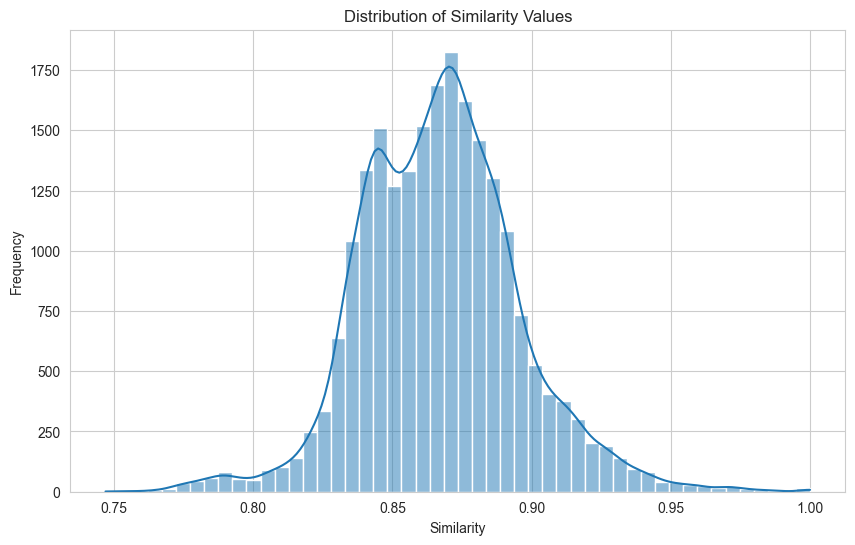

In [211]:
# Show Similarity Distribution
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = gwas_mesh_df
df_sorted = df.sort_values(by='similarity')#[:20]
# Plot the distribution of the 'similarity' values
plt.figure(figsize=(10, 6))
sns.histplot(df_sorted['similarity'], bins=50, kde=True)
plt.title('Distribution of Similarity Values')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.show()

In [30]:
if simple_bool('save corr table?'): gwas_mesh_df.to_csv('gwas_data/gwas_mesh_correspondance_nutrigen.csv', index=False)

if simple_bool('load corr table?'): gwas_mesh_df = pd.read_csv('gwas_data/gwas_mesh_correspondance_nutrigen.csv')

In [13]:
gwas_mesh_df_threshold = gwas_mesh_df[gwas_mesh_df.similarity>=0.9]
gwas_mesh_df_threshold[gwas_mesh_df_threshold.mesh.isin(grpm_meshs)]
grpm_meshs[grpm_meshs.isin(gwas_mesh_df_threshold.mesh)]

0                      Body Mass Index
2                                 Diet
4              Cardiovascular Diseases
5                              Obesity
6                     Body Composition
                      ...             
1113483                     Metabolism
1116003            Adenoma, Liver Cell
1116127                  Glycosylation
1144395    NADH, NADPH Oxidoreductases
1166849         Ketone Oxidoreductases
Name: mesh, Length: 376, dtype: object

### IV. Merge Nutrigen-GRPM and GWAS

In [18]:
df_gwas_.sample(20)

Index(['DATE ADDED TO CATALOG', 'PUBMEDID', 'FIRST AUTHOR', 'DATE', 'JOURNAL',
       'LINK', 'STUDY', 'DISEASE/TRAIT', 'INITIAL SAMPLE SIZE',
       'REPLICATION SAMPLE SIZE', 'REGION', 'CHR_ID', 'CHR_POS',
       'REPORTED GENE(S)', 'MAPPED_GENE', 'UPSTREAM_GENE_ID',
       'DOWNSTREAM_GENE_ID', 'SNP_GENE_IDS', 'UPSTREAM_GENE_DISTANCE',
       'DOWNSTREAM_GENE_DISTANCE', 'STRONGEST SNP-RISK ALLELE', 'SNPS',
       'MERGED', 'SNP_ID_CURRENT', 'CONTEXT', 'INTERGENIC',
       'RISK ALLELE FREQUENCY', 'P-VALUE', 'PVALUE_MLOG', 'P-VALUE (TEXT)',
       'OR or BETA', '95% CI (TEXT)', 'PLATFORM [SNPS PASSING QC]', 'CNV',
       'MAPPED_TRAIT', 'MAPPED_TRAIT_URI', 'STUDY ACCESSION',
       'GENOTYPING TECHNOLOGY'],
      dtype='object')


,DATE ADDED TO CATALOG,PUBMEDID,FIRST AUTHOR,DATE,JOURNAL,LINK,STUDY,DISEASE/TRAIT,INITIAL SAMPLE SIZE,REPLICATION SAMPLE SIZE,...,PVALUE_MLOG,P-VALUE (TEXT),OR or BETA,95% CI (TEXT),PLATFORM [SNPS PASSING QC],CNV,MAPPED_TRAIT,MAPPED_TRAIT_URI,STUDY ACCESSION,GENOTYPING TECHNOLOGY
21940,2020-12-14,32042192,Ruth KS,2020-02-10,Nat Med,www.ncbi.nlm.nih.gov/pubmed/32042192,Using human genetics to understand the disease...,Sex hormone-binding globulin levels adjusted f...,"180,094 European ancestry men",None,...,10.154902,None,0.007926,[0.0055-0.0104] unit increase,Affymetrix [16582621] (imputed),N,sex hormone-binding globulin measurement,http://www.ebi.ac.uk/efo/EFO_0004696,GCST90012108,Genome-wide genotyping array
130537,2022-04-27,35213538,Richardson TG,2022-02-25,PLoS Biol,www.ncbi.nlm.nih.gov/pubmed/35213538,Characterising metabolomic signatures of lipid...,Glucose levels,"114,870 European ancestry individuals",None,...,9.698970,None,0.026057,[0.018-0.034] unit decrease,NR [11722792] (imputed),N,glucose measurement,http://www.ebi.ac.uk/efo/EFO_0004468,GCST90092819,Genome-wide genotyping array
88172,2019-03-25,30804566,Lane JM,2019-02-25,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/30804566,Biological and clinical insights from genetics...,Insomnia symptoms (never/rarely vs. usually),"129,270 European ancestry cases, 108,357 Europ...","17,140 European ancestry cases, 61,850 Europea...",...,11.154902,None,1.020000,[1.01-1.03],Affymetrix [14661600] (imputed),N,insomnia measurement,http://www.ebi.ac.uk/efo/EFO_0007876,GCST007388,Genome-wide genotyping array
223439,2022-08-19,35872910,Carcel-Marquez J,2022-07-08,Front Cardiovasc Med,www.ncbi.nlm.nih.gov/pubmed/35872910,A Polygenic Risk Score Based on a Cardioemboli...,Cardioembolic stroke (MTAG),"362,661 European ancestry individuals",None,...,11.000000,None,6.790000,z score increase,Illumina [6808676] (imputed),N,cardioembolic stroke,http://www.ebi.ac.uk/efo/EFO_1001976,GCST90132228,Genome-wide genotyping array
46380,2020-05-21,31969693,Coleman JRI,2020-01-23,Mol Psychiatry,www.ncbi.nlm.nih.gov/pubmed/31969693,Genome-wide gene-environment analyses of major...,Major depressive disorder in trauma-unexposed ...,"9,487 European ancestry cases, 39,677 European...",None,...,6.000000,None,1.152074,[1.09-1.21],Affymetrix [7791636] (imputed),N,major depressive disorder,http://purl.obolibrary.org/obo/MONDO_0002009,GCST009981,Genome-wide genotyping array
253699,2022-12-14,36477530,Saunders GRB,2022-12-07,Nature,www.ncbi.nlm.nih.gov/pubmed/36477530,Genetic diversity fuels gene discovery for tob...,Smoking initiation,"3,382,012 European ancestry, East Asian ancest...",None,...,18.522879,None,0.010400,[0.0082-0.0126] unit increase,NR [NR] (imputed),N,smoking initiation,http://www.ebi.ac.uk/efo/EFO_0005670,GCST90243985,"Genome-wide genotyping array, Genome-wide sequ..."
100807,2023-01-10,29875488,Sun BB,2018-06-06,Nature,www.ncbi.nlm.nih.gov/pubmed/29875488,Genomic atlas of the human plasma proteome.,Carbonyl reductase [NADPH] 3 levels (CBR3.1409...,"3,301 European ancestry individuals",None,...,45.397940,None,0.560000,[-0.48--0.64] unit decrease,Affymetrix [10572788] (imputed),N,carbonyl reductase [NADPH] 3 measurement,http://www.ebi.ac.uk/efo/EFO_0803315,GCST90240594,Genome-wide genotyping array
150925,2017-08-30,27863252,Astle WJ,2016-11-17,Cell,www.ncbi.nlm.nih.gov/pubmed/27863252,The Allelic Landscape of Human Blood Cell Trai...,Mean corpuscular hemoglobin,"172,332 European ancestry individuals",None,...,99.698970,None,0.217082,[0.2-0.24] unit decrease,Affymetrix [~ 2500000] (imputed),N,mean corpuscular hemoglobin,http://www.ebi.ac.uk/efo/EFO_0004527,GCST004630,Genome-wide genotyping array
229822,2024-02-08,36357675,Surendran P,2022-11-10,Nat Med,www.ncbi.nlm.nih.gov/pubmed/36357675,Rare and common genetic determinants of metabo...,Imidazole propionate levels,"14,296 European ancestry individuals","5,698 European ancestry individuals",...,33.000000,None,0.134375,[0.11-0.16] unit increase,Affymetri

In [27]:
df_gwas_small = df_gwas_[['SNPS','CONTEXT','DISEASE/TRAIT','MAPPED_TRAIT', 'STRONGEST SNP-RISK ALLELE', 'MAPPED_GENE', 'OR or BETA', 'STUDY','STUDY ACCESSION']].drop_duplicates()

display(df_gwas_small)
display(grpm_nutrigen_int.head())

,SNPS,CONTEXT,DISEASE/TRAIT,MAPPED_TRAIT,STRONGEST SNP-RISK ALLELE,MAPPED_GENE,OR or BETA,STUDY,STUDY ACCESSION
0,rs960417,intron_variant,Prostate cancer,prostate carcinoma,rs960417-A,SHROOM2,1.074788,Trans-ancestry genome-wide association meta-an...,GCST011048
1,rs5972255,intron_variant,Prostate cancer,prostate carcinoma,rs5972255-T,TAB3,1.067790,Trans-ancestry genome-wide association meta-an...,GCST011048
2,rs11338635,intron_variant,Prostate cancer,prostate carcinoma,rs11338635-GA,LINC01496,1.083639,Trans-ancestry genome-wide association meta-an...,GCST011048
3,rs58235267,intron_variant,Prostate cancer,prostate carcinoma,rs58235267-G,OTX1,1.122000,Trans-ancestry genome-wide association meta-an...,GCST011047
4,rs74001374,intron_variant,Prostate cancer,prostate carcinoma,rs74001374-C,MLPH,1.147000,Trans-ancestry genome-wide association meta-an...,GCST011047
...,...,...,...,...,...,...,...,...,...
292103,rs2343522,intron_variant,Educational attainment,educational attainment,rs2343522-T,RBFOX1,0.008107,Polygenic prediction of educational attainment...,GCST90105038
292104,rs8044082,intron_variant,Educational attainment,educational attainment,rs8044082-T,RBFOX1,0.007181,Polygenic prediction of educational attainment...,GCST90105038
292105,rs722256,intron_variant,Educational attainment,educational attainment,rs722256-C,RBFOX1,0.006546,Polygenic prediction of educational attainment...,GCST90105038
292106,rs10400992,intron_variant,Educational attainment,educational attainment,rs10400992-C,RBFOX1,0.006071,Polygenic prediction of educational attainment...,GCST90105038


,gene,rsid,pmids,mesh,topic,interest_index
0,FTO,rs9972653,32393786,Body Mass Index,General Nutrition,1.0
1,FTO,rs9972653,32393786,"Diabetes Mellitus, Type 2",General Nutrition,1.0
2,FTO,rs9972653,32393786,Diet,General Nutrition,1.0
3,FTO,rs9972653,33128006,Body Mass Index,General Nutrition,1.0
4,FTO,rs9972653,33128006,Cardiovascular Diseases,General Nutrition,1.0


In [28]:
def typestr(df):
    df[['pmid','PUBMEDID']] = df[['pmid','PUBMEDID']].astype(str)

#df_grpmx_th_int = df_grpmx_th_int.sort_values(by=['interest_index','rsid','mesh'], ascending =False).reset_index(drop=True)

# Merge two df on rsid:
df_merged_th = pd.merge(grpm_nutrigen_int,
                        df_gwas_small, left_on='rsid', right_on='SNPS')

In [ ]:
df_merged_th[['rsid', 'SNPS', 'mesh', 'DISEASE/TRAIT', 'STRONGEST SNP-RISK ALLELE']].sample(20)

In [15]:
df_merged_th.sample(20)

,gene,rsid,pmids,mesh,topic,interest_index,SNPS,DISEASE/TRAIT,MAPPED_TRAIT,STRONGEST SNP-RISK ALLELE
6946728,APOE,rs7412,23919842,Dyslipidemias,Diabetes Mellitus Type II and Metabolic Syndrome,0.59909,rs7412,Triglycerides to total lipids ratio in very sm...,"triglycerides:total lipids ratio, very low den...",rs7412-T
16616135,FCGR3A,rs396991,26736041,Immunoglobulin G,Food Allergies,0.33372,rs396991,Low affinity immunoglobulin gamma Fc region re...,level of low affinity immunoglobulin gamma Fc ...,rs396991-C
12297924,AGT,rs699,17298481,Hypertension,Cardiovascular Health and Lipid Metabolism,0.59079,rs699,Diastolic blood pressure,diastolic blood pressure,rs699-A
16702421,PNPLA3,rs738409,23226254,Fatty Liver,Xenobiotics Metabolism,1.00000,rs738409,Platelet count,platelet count,rs738409-C
7461612,APOE,rs429358,11425239,Apolipoproteins E,Diabetes Mellitus Type II and Metabolic Syndrome,0.59909,rs429358,Platelet-activating factor acetylhydrolase levels,protein measurement,rs429358-T
1649298,TM6SF2,rs58542926,34384788,Lipid Metabolism,General Nutrition,0.27377,rs58542926,Linoleic acid levels,linoleic acid measurement,rs58542926-C
13697347,APOB,rs676210,31132756,"Lipoproteins, LDL",Cardiovascular Health and Lipid Metabolism,0.35086,rs676210,Cholesterol levels in large VLDL,"total cholesterol measurement, very low densit...",rs676210-G
4229935,FTO,rs1121980,26722565,Polycystic Ovary Syndrome,"Obesity, Weight Control and Compulsive Eating",1.00000,rs1121980,High density lipoprotein cholesterol levels,high density lipoprotein cholesterol measurement,rs1121980-G
7510604,APOE,rs429358,28686695,Apolipoproteins E,Diabetes Mellitus Type II and Metabolic Syndrome,0.59909,rs429358,Free cholesterol in large HDL,free cholesterol in large HDL measurement,rs429358-T
76799,MTHFR,rs1801133,21960995,Blood Glucose,General Nutrition,0.84255,rs1801133,Homocysteine levels,homocysteine measurement,rs1801133-A


### V. Filer Joint DF by Semantic Similarity

['SNPS','CONTEXT','DISEASE/TRAIT','MAPPED_TRAIT', 'STRONGEST SNP-RISK ALLELE', 'MAPPED_GENE', 'OR or BETA', 'STUDY','STUDY ACCESSION']

In [33]:
# Load correspodance tabel
if 'gwas_mesh_df_threshold' not in globals():
    gwas_mesh_df = pd.read_csv('gwas_data/gwas_mesh_correspondance_nutrigen.csv')
    gwas_mesh_df_threshold = gwas_mesh_df[gwas_mesh_df.similarity>=0.9]

# First, merge the two dataframes on the specified combinations
merged_df = df_merged_th.merge(
    gwas_mesh_df_threshold,
    left_on=['DISEASE/TRAIT', 'mesh'],
    right_on=['gwas_trait', 'mesh'],
    how='inner'
)

# Generate a report of the count of unique elements in each column
report = merged_df.nunique()

# Print the report count of unique elements in the DataFrame
print("Unique elements count in each column:")
print(report)
#merged_df.groupby('gene').describe(include='object').loc[:, (slice(None), 'unique')]

Unique elements count in each column:
gene                          385
rsid                          944
pmids                        7278
mesh                          126
topic                          10
interest_index                835
SNPS                          944
CONTEXT                        12
DISEASE/TRAIT                 588
MAPPED_TRAIT                  316
STRONGEST SNP-RISK ALLELE    1211
MAPPED_GENE                   383
OR or BETA                   3911
STUDY                         380
STUDY ACCESSION              1140
gwas_trait                    588
similarity                    578
dtype: int64


In [64]:
# Refine Datset
dict_ = {'gene' :   'GRPM_GENE', 
         'rsid' :   'GRPM_RSID', 
         'pmid':   'GRPM_PMID', 
         'mesh' :   'GRPM_MESH',
         'topic':  'GRPM_TOPIC',
         'interest_index': 'GRPM_GI',
         'similarity': 'SEMANTIC_SIMILARITY',
         'DISEASE/TRAIT': 'GWAS_DISEASE/TRAIT',
         'MAPPED_TRAIT': 'GWAS_MAPPED_TRAIT',
         'MAPPED_GENE': 'GWAS_MAPPED_GENE',
         #'SNPS': 'GWAS_SNPS',
        'CONTEXT': 'GWAS_CONTEXT',
        'STRONGEST SNP-RISK ALLELE': 'GWAS_STRONGEST_SNP-RISK_ALLELE',
        'OR or BETA': 'GWAS_OR-BETA',
        'STUDY': 'GWAS_STUDY',
        'STUDY ACCESSION': 'GWAS_STUDY_ID',
        #'gwas_trait',
        }

merged_df.rename(columns=dict_, inplace=True)
merged_df = merged_df[dict_.values()]

In [67]:
if simple_bool('Save merge output?'): merged_df.to_parquet('nutrigenetic_dataset/grpm_nutrigen_int_gwas.parquet', engine='pyarrow', index=False)

In [73]:
merged_df = pd.read_parquet('nutrigenetic_dataset/grpm_nutrigen_int_gwas.parquet')#.describe(include= object).T
merged_df.nunique()#.describe(include=object).T

GRPM_GENE                          385
GRPM_RSID                          944
GRPM_PMID                         7278
GRPM_MESH                          126
GRPM_TOPIC                          10
GRPM_GI                            835
SEMANTIC_SIMILARITY                578
GWAS_DISEASE/TRAIT                 588
GWAS_MAPPED_TRAIT                  316
GWAS_MAPPED_GENE                   383
GWAS_CONTEXT                        12
GWAS_STRONGEST_SNP-RISK_ALLELE    1211
GWAS_OR-BETA                      3911
GWAS_STUDY                         380
GWAS_STUDY_ID                     1140
dtype: int64

GRPM-GWAS Nutrigentic Dataset:
Genes	: 385
variations	: 944
pmid  : 7278
mesh : 126

GRPM Nutrigentic Dataset:
Genes	: 1773
variations	: 63.581
pmid  : 99.759
mesh : 1486

NutriGenDB Statistics
Genes	: 161
variations	: 248


In [74]:
nutri_df = pd.read_parquet('nutrigenetic_dataset/grpm_nutrigen_int.parquet')#.describe(include= object).T
nutri_df.nunique()#.describe(include=object).T

gene               1773
rsid              63581
pmids             99759
mesh               1486
topic                10
interest_index     2635
dtype: int64

In [62]:
merged_df.loc[merged_df['GRPM_GENE'] == merged_df['GWAS_MAPPED_GENE'], ['GRPM_GENE', 'GWAS_MAPPED_GENE']].drop_duplicates()
#merged_df[['GRPM_GENE']].drop_duplicates()

merged_df.loc[merged_df['GRPM_GENE'] != merged_df['GWAS_MAPPED_GENE']]
merged_df.loc[merged_df['GRPM_RSID'] != merged_df['GWAS_SNPS']]

,GRPM_GENE,GRPM_RSID,GRPM_PMID,GRPM_MESH,GRPM_TOPIC,GRPM_GI,SEMANTIC_SIMILARITY,GWAS_DISEASE/TRAIT,GWAS_MAPPED_TRAIT,GWAS_MAPPED_GENE,GWAS_SNPS,GWAS_CONTEXT,GWAS_STRONGEST_SNP-RISK_ALLELE,GWAS_OR-BETA,GWAS_STUDY,GWAS_STUDY_ID


## NLP-based Method [DEPRECATED]

### I. choose and load GRPM survey to merge

In [ ]:
# choose db
db_tag = 'pcg'
# pcg    = protein coding genes = grpm_db_pcg
# rna    = rna genes            = grpm_db_rna
# pseudo = pseudogenes          = grpm_db_pseudo
#-------------------------------------------------

survey_path = 'grpm_surveys/'

# Create an empty list to store folder names
folder_names = []
current_dir = os.getcwd()+'/'+survey_path
# Iterate over the directories in the workspace
for root, dirs, files in os.walk(current_dir):
    for dir_name in dirs:
        # Check if the folder name contains the string 'survey'
        if 'survey' in dir_name:
            folder_names.append(dir_name)

# Create a pandas Series from the list of folder names
folder_series = pd.Series(folder_names)
print('Available survey repositories:\n')
folder_series = folder_series.str.replace('grpm_survey_'+db_tag+'_','')
# Print the resulting Series
print(folder_series)

In [ ]:
# load my GRPMx Data from survey folder
tag = 'nutri'
directory = survey_path+'grpm_survey_pcg_'+tag
df_grpmx = pd.read_csv(directory+'/grpmx_filtered_output.csv', index_col=0)
df_grpmx_repo = pd.read_csv(directory+'/GRPMX_report_int.csv')

# add mesh synonyms
mesh_df = pd.read_csv('ref-mesh/MESH_STY_LITVAR1.csv')[['Preferred Label', 'Synonyms']]
df_grpmx = pd.merge(df_grpmx,
                            mesh_df, left_on='mesh',right_on='Preferred Label')
mesh_df = None

df_grpmx = df_grpmx.drop('Preferred Label', axis = 1)
df_grpmx['all_mesh'] = df_grpmx['mesh'] + ', ' + df_grpmx['Synonyms']


#def function: filter for int threshold:
def filter_int(df_repo, threshold ):
    df_grpmx_repo_int = df_repo[df_repo.interest_index >= threshold]
    return df_grpmx[df_grpmx.gene.isin(df_grpmx_repo_int.gene)]

#filter for 0.95 quantile
df_grpmx_95 = filter_int(df_grpmx_repo, threshold=df_grpmx_repo.interest_index.quantile(0.95))

#filter for int threshold:
df_grpmx_int = filter_int(df_grpmx_repo, threshold=0.0125)

print('df_grpmx_95 genes:', df_grpmx_95.gene.nunique())
print('df_grpmx_int genes:', df_grpmx_int.gene.nunique())

df_grpmx_int

### II. set Gene Interest threshold

In [ ]:
#threshold
#df_grpmx_th = df_grpmx_95
df_grpmx_th = df_grpmx_int

df_grpmx_int = pd.DataFrame()
df_grpmx_th_int = pd.DataFrame()

## ADD gene-interest index as common sorting handle
small_dummy = df_grpmx_repo[['gene','interest_index']]
df_grpmx_int =    pd.merge(df_grpmx,    small_dummy, left_on='gene', right_on='gene')
df_grpmx_th_int = pd.merge(df_grpmx_th, small_dummy, left_on='gene', right_on='gene')

print('GRPMX threshold Statistics:')
print('genes:', df_grpmx_th.gene.nunique())
print('rsid:',  df_grpmx_th .rsid.nunique())
print('mesh:',  df_grpmx_th .mesh.nunique())

df_grpmx_int
df_grpmx_th_int

### III. merge gwas_df with grpmx dataset

#### - complete grpmx merge

In [ ]:
merge_with = clean_df_gwas # or full df_gwas

#------------------------------------------

#merge_with = df_gwas # or full df_gwas
def typestr(df):
    df[['pmid','PUBMEDID']] = df[['pmid','PUBMEDID']].astype(str)

# sort grpmx geeens by interest index:

#common handle sort
df_grpmx_int = df_grpmx_int.sort_values(by=['interest_index','rsid','mesh'], ascending =False).reset_index(drop=True)

timea = datetime.now()
print('merging data, please wait... ')
# Merge two df on rsid:
df_merged = pd.merge(df_grpmx_int,
                     merge_with, left_on='rsid', right_on='SNPS')
typestr(df_merged)

df_merged_drop = pd.merge(df_grpmx_int,
                          df_gwas_drop_nonan, left_on='rsid', right_on='SNPS')
typestr(df_merged_drop)

#rename columns:
def rename_col(df):
    return df.rename(columns={'gene':'LITVAR_GENE', 'rsid':'LIVAR_RSID', 'pmid':'LITVAR_PMID','mesh':'PUBMED_MESH'}, inplace=True)
rename_col(df_merged)
rename_col(df_merged_drop)

print('runtime:', datetime.now()-timea)
df_merged_drop[['LITVAR_GENE','MAPPED_GENE','PUBMED_MESH','all_mesh','DISEASE/TRAIT','MAPPED_TRAIT']].drop_duplicates()

In [ ]:
#stats
print('Complete grpmx merge Stats\n')

print('grpmx_gene',df_grpmx_int.gene.nunique())
print('grpmx_mesh',df_grpmx_int.mesh.nunique())
print('grpmx_rsid',df_grpmx_int.rsid.nunique())

#print('\nnonan',len(df_merged_drop),', full:', len(df_merged))
df_merged_drop[['LITVAR_GENE','LIVAR_RSID','DISEASE/TRAIT','STRONGEST SNP-RISK ALLELE']].drop_duplicates()
print('df merged:')
print(df_merged_drop[['LITVAR_GENE','LITVAR_PMID','PUBMED_MESH','LIVAR_RSID','DISEASE/TRAIT','STRONGEST SNP-RISK ALLELE']].nunique())

df_merged_drop[['LITVAR_GENE','LIVAR_RSID','PUBMED_MESH','DISEASE/TRAIT','STRONGEST SNP-RISK ALLELE']].drop_duplicates()

#### - threshold grpmx merge
(it's better top apply threshold downstream, skip this)

In [ ]:
# threshold merge on SNPs
merge_also_nonan = True

def typestr(df):
    df[['pmid','PUBMEDID']] = df[['pmid','PUBMEDID']].astype(str)

df_grpmx_th_int = df_grpmx_th_int.sort_values(by=['interest_index','rsid','mesh'], ascending =False).reset_index(drop=True)


# Merge two df on rsid:
if merge_also_nonan == False:
    df_merged_th = pd.merge(df_grpmx_th_int,
                            df_gwas, left_on='rsid', right_on='SNPS')
    typestr(df_merged_th)
else:
    df_merged_th = pd.merge(df_grpmx_th_int,
                            df_gwas, left_on='rsid', right_on='SNPS')
    typestr(df_merged_th)

    df_merged_th_drop = pd.merge(df_grpmx_th_int,
                                 df_gwas_drop_nonan, left_on='rsid', right_on='SNPS')
    typestr(df_merged_th_drop)

#rename columns:
def rename_col(df):
    return df.rename(columns={'gene':'LITVAR_GENE', 'rsid':'LIVAR_RSID', 'pmid':'LITVAR_PMID','mesh':'PUBMED_MESH'}, inplace=True)
rename_col(df_merged_th_drop)
rename_col(df_merged_th)

print('genes merged:', df_merged_th_drop.LITVAR_GENE.nunique())
df_merged_th_drop

In [ ]:
#stats
print('Threshold grpmx merge Statistics:\n')
print('grpmx_gene',df_grpmx_th_int.gene.nunique())
print('grpmx_mesh',df_grpmx_th_int.mesh.nunique())
print('grpmx_rsid',df_grpmx_th_int.rsid.nunique())

print('\nfull threshold merge pmids:',df_merged_th.LITVAR_PMID.nunique(),
      'threshold pmids:',df_merged_th_drop.LITVAR_PMID.nunique())
#df_merged_95_drop[['gene','rsid','mesh','DISEASE/TRAIT','STRONGEST SNP-RISK ALLELE']].drop_duplicates()
print('\ngrpm merged with gwas stats:')
print(df_merged_th_drop[['LITVAR_GENE','LITVAR_PMID','PUBMED_MESH','LIVAR_RSID','DISEASE/TRAIT','STRONGEST SNP-RISK ALLELE']].nunique())

In [ ]:
import matplotlib.pyplot as plt

def visualize_unique_values(df):
    unique_counts = df.nunique()  # Calculate the number of unique values for each column
    plt.figure(figsize=(8,3))
    unique_counts.plot(kind='bar')  # Create a bar plot
    plt.xlabel('Columns')
    plt.ylabel('Unique Values')
    plt.title('Number of Unique Values per Column')
    plt.show()
visualize_unique_values(df_merged_th_drop)

In [ ]:
# complete grpmx merge stats:

# value counts:
print('GWAS TRAIT count in entire GRPM survey')
df_merged.value_counts('DISEASE/TRAIT')

In [ ]:
print('GWAS TRAIT count (nonan) in entire grpmx')
df_merged_drop.value_counts('DISEASE/TRAIT')

In [ ]:
#df_merged_drop_nonan.to_csv('gwas_data/df_merged_drop_nonan.csv') # heavy file!
def df_usage(df):
    return (df.memory_usage()/1048576).sum()

print(df_usage(df_merged))
print(df_usage(df_merged_th_drop))

### IV. Filter for lexical match

#### - create correspondence GWAS-GRPM df
['PUBMED_MESH','DISEASE/TRAIT']

In [ ]:
print(df_merged_drop[['LITVAR_GENE','MAPPED_GENE']].nunique())
print('')
# choosing 'DISEASE/TRAIT' or 'MAPPED_TRAIT'
print(df_merged_drop[['DISEASE/TRAIT','MAPPED_TRAIT','PUBMED_MESH' ]].nunique())
df_merged_drop[['DISEASE/TRAIT','MAPPED_TRAIT' ]].drop_duplicates()

In [ ]:
# create correspondence GWAS-GRPM df
mesh_col = 'all_mesh'
corr_df_all = df_merged_drop[[mesh_col,'MAPPED_TRAIT' ]].drop_duplicates().reset_index(drop= True).dropna()
print('PUBMED_MESH',   corr_df_all[mesh_col].nunique())
print('MAPPED_TRAIT' , corr_df_all['MAPPED_TRAIT' ].nunique())
print('rows' ,     len(corr_df_all))
#print(corr_df.sort_values(by= mesh_col))

mesh_col = 'PUBMED_MESH'
corr_df = df_merged_drop[[mesh_col,'MAPPED_TRAIT' ]].drop_duplicates().reset_index(drop= True)
print('\nPUBMED_MESH',   corr_df[mesh_col].nunique())
print(  'MAPPED_TRAIT' , corr_df['MAPPED_TRAIT' ].nunique())
print(  'rows' ,         len(corr_df))

In [ ]:
corr_df.sort_values(by= 'PUBMED_MESH')

In [ ]:
#corr_df[mesh_col].drop_duplicates()
df_merged_drop
#mesh  363

#### - build a common Dictionary

In [ ]:
mesh_col = 'PUBMED_MESH'
meshes = corr_df.sort_values(by= mesh_col)[mesh_col].drop_duplicates()
mesh_corr_df = corr_df[corr_df[mesh_col] == meshes.iloc[100]]

# Correspondence through AI  (trial)
if simple_bool('Try Correspondence through AI?'):
    import pychatgpt as op
    mess = "analyze and filter the csv below, creating another csv keeping only the rows where the 'PUBMED_MESH' and 'MAPPED_TRAIT' are the exact same biological entity even though it could be written differently:\n\n"+mesh_corr_df.to_csv(index=None)
    op.ask_gpt(mess)#, maxtoken=1500)
    mesh_corr_df

#### - through Tokenization (nltk)

In [ ]:
# Correspondence dictionary through Tokenization:

from nltk.tokenize import word_tokenize

# choose df:
df = corr_df_all
mesh_col = 'all_mesh'

if False: #(pseudo-code)
    # Function to tokenize a string into individual words
    def tokenize_string(text):
        return set(word_tokenize(text.lower()))

    # Filter the DataFrame based on the condition that the intersection of tokenized "PUBMED MESH" and "MAPPED_TRAIT" is not empty
    filtered_df = df[df.apply(lambda row: bool(tokenize_string(row[mesh_col]) & tokenize_string(row['MAPPED_TRAIT'])), axis=1)]

    tokenize_string(corr_df[mesh_col][2])
    n =55
    bool(tokenize_string(corr_df[mesh_col][n]) & tokenize_string(corr_df['MAPPED_TRAIT'][n]))
    print(tokenize_string_trial(corr_df[mesh_col][n]))
    print(tokenize_string(corr_df[mesh_col][n]))
#-------------

print('tokenization in progress, please wait...')
# choosen token TAGs:
def tokenize_string_trial(text):
    tokens = set(word_tokenize(text.lower()))
    tagged_tokens = nltk.pos_tag(tokens)
    desired_tags = ['NN', 'NNS', 'JJ']
    filtered_tokens = [token for token, pos in tagged_tokens if pos in desired_tags]
    return set(filtered_tokens)

timea = datetime.now()
filtered_df = df[df.apply(lambda row: bool(tokenize_string_trial(row[mesh_col]) & tokenize_string_trial(row['MAPPED_TRAIT'])), axis=1)]
timeb= datetime.now()
print('runtime:', timeb-timea)

filtered_df

### V. merging Dictionay to GWAS_GRPM_df

In [ ]:
df_merged_drop.all_mesh
filtered_df.all_mesh

In [ ]:
# filtering merge:
mesh_col = 'all_mesh'
merge_grpm_gwas_fliter = df_merged_drop.merge(filtered_df, on=[mesh_col,'MAPPED_TRAIT'])
df_show = merge_grpm_gwas_fliter[['LITVAR_GENE','LIVAR_RSID', 'LITVAR_PMID', 'PUBMED_MESH', 'Synonyms','interest_index','MAPPED_GENE','PUBMED_MESH','DISEASE/TRAIT','MAPPED_TRAIT', 'STRONGEST SNP-RISK ALLELE','P-VALUE', 'OR or BETA']].drop_duplicates().reset_index(drop= True)
df_show = df_show.loc[:, ~df_show.columns.duplicated()]
df_show

In [ ]:
df_show.to_csv('gwas_data/merge_grpm_gwas_fliter_nutri_0725.csv')
pd.read_csv('gwas_data/merge_grpm_gwas_fliter_nutri_0725.csv')

#statistics
print(df_show[['LITVAR_GENE','LIVAR_RSID','LITVAR_PMID','PUBMED_MESH','MAPPED_TRAIT','DISEASE/TRAIT','STRONGEST SNP-RISK ALLELE']].nunique())

### apply GI threshold

In [ ]:
# filtering fot threshold GI:
threshold = 0.0125
df_show_th = df_show[df_show.interest_index >= threshold]

df_show_th.to_csv('gwas_data/merge_grpm_gwas_fliter_nutri_th0136.csv')
print('merged GWAS-GRPMX threshold:', threshold,'\n')
print(df_show_th[['LITVAR_GENE','MAPPED_GENE','PUBMED_MESH','MAPPED_TRAIT','DISEASE/TRAIT','STRONGEST SNP-RISK ALLELE']].nunique())

df_thr_short= df_show_th[['LITVAR_GENE','LIVAR_RSID','LITVAR_PMID','PUBMED_MESH','MAPPED_TRAIT','DISEASE/TRAIT','STRONGEST SNP-RISK ALLELE']]
df_thr_short#.to_csv(r'file_name.csv')
df_show_th.columns

In [ ]:
df_thr_short.drop_duplicates(subset='LITVAR_GENE').sample(frac=1)#.to_csv('file_name.csv')

In [ ]:
if simple_bool('Save merged output?'): df_thr_short.to_parquet('nutrigenetic_dataset/grpm_nutrigen_int_gwas_nlp.parquet', engine='pyarrow', index=False)

# 4. Scoping GWAS Dataset (general)

## Define Mother Dataframe:

In [75]:
if simple_bool('Load merge output?'): merged_df = pd.read_parquet('nutrigenetic_dataset/grpm_nutrigen_int_gwas.parquet', engine='pyarrow')

## - Query GWAS for rsid

In [25]:
# LOOKUP FOR SINGLE RSID
rsid_mask = df_gwas_drop_nonan['SNPS'].str.contains('rs1421085')
df_gwas_drop_nonan_rsid = df_gwas_drop_nonan[rsid_mask]
df_gwas_drop_nonan_rsid[['MAPPED_GENE','DISEASE/TRAIT','MAPPED_TRAIT','SNP_ID_CURRENT','STRONGEST SNP-RISK ALLELE','RISK ALLELE FREQUENCY']].drop_duplicates()
df_gwas_drop_nonan_rsid.value_counts('DISEASE/TRAIT')
df_gwas_drop_nonan_rsid.value_counts('STRONGEST SNP-RISK ALLELE')

STRONGEST SNP-RISK ALLELE
rs1421085-C    39
rs1421085-T    21
rs1421085-A     1
Name: count, dtype: int64

In [0]:
# Display and to clipboard
df_gwas_drop_nonan[['MAPPED_GENE', 'DISEASE/TRAIT', 'SNPS','STRONGEST SNP-RISK ALLELE', 'RISK ALLELE FREQUENCY']].drop_duplicates()#to_clipboard()

In [28]:
df_gwas_drop_nonan_rsid[['MAPPED_GENE', 'DISEASE/TRAIT', 'SNPS','STRONGEST SNP-RISK ALLELE', 'RISK ALLELE FREQUENCY']].drop_duplicates()#.to_clipboard()

,MAPPED_GENE,DISEASE/TRAIT,SNPS,STRONGEST SNP-RISK ALLELE,RISK ALLELE FREQUENCY
2678,FTO,Total testosterone levels,rs1421085,rs1421085-T,0.594668
7293,FTO,Hand grip strength,rs1421085,rs1421085-C,0.4
11358,FTO,Chronotype,rs1421085,rs1421085-C,0.4065
12542,FTO,Morning person,rs1421085,rs1421085-C,0.4065
14326,FTO,Type 2 diabetes,rs1421085,rs1421085-C,0.367
15701,FTO,Alcohol consumption,rs1421085,rs1421085-T,0.6
19243,FTO,Type 2 diabetes,rs1421085,rs1421085-C,0.2
19522,FTO,Bone mineral density or leg lean mass (pleiotr...,rs1421085,rs1421085-T,0.59
19523,FTO,Leg lean mass,rs1421085,rs1421085-T,0.59
21682,FTO,Body size at age 10,rs1421085,rs1421085-T,0.596552


In [32]:
merged_df
#['LITVAR_GENE','LIVAR RSID','MAPPED_GENE','PUBMED_MESH', 

,gene,rsid,pmids,mesh,topic,interest_index,SNPS,DISEASE/TRAIT,MAPPED_TRAIT,gwas_trait,similarity
0,FTO,rs9941349,22084931,Obesity,General Nutrition,1.00000,rs9941349,Obesity (extreme),obesity,Obesity (extreme),0.909086
1,FTO,rs9941349,20442772,Obesity,General Nutrition,1.00000,rs9941349,Obesity (extreme),obesity,Obesity (extreme),0.909086
2,FTO,rs9941349,24879436,Obesity,General Nutrition,1.00000,rs9941349,Obesity (extreme),obesity,Obesity (extreme),0.909086
3,FTO,rs9941349,21552555,Obesity,General Nutrition,1.00000,rs9941349,Obesity (extreme),obesity,Obesity (extreme),0.909086
4,FTO,rs9941349,25014319,Obesity,General Nutrition,1.00000,rs9941349,Obesity (extreme),obesity,Obesity (extreme),0.909086
...,...,...,...,...,...,...,...,...,...,...,...
88385,ALDH2,rs671,22102315,Liver Cirrhosis,Xenobiotics Metabolism,0.01714,rs671,Cirrhosis,cirrhosis of liver,Cirrhosis,0.947730
88386,ALDH2,rs671,27118149,Liver Cirrhosis,Xenobiotics Metabolism,0.01714,rs671,Cirrhosis,cirrhosis of liver,Cirrhosis,0.947730
88387,ALDH2,rs671,31279903,Liver Cirrhosis,Xenobiotics Metabolism,0.01714,rs671,Cirrhosis,cirrhosis of liver,Cirrhosis,0.947730
88388,ALDH2,rs671,34071962,Liver Cirrhosis,Xenobiotics Metabolism,0.01714,rs671,Cirrhosis,cirrhosis of liver,Cirrhosis,0.947730


In [38]:
# LOOKUP FOR SINGLE RSID
df_merged_drop_nonan_rsid = merged_df[merged_df['rsid'].str.contains('rs1421085')]
df_merged_drop_nonan_rsid

,gene,rsid,pmids,mesh,topic,interest_index,SNPS,DISEASE/TRAIT,MAPPED_TRAIT,gwas_trait,similarity
1064,FTO,rs1421085,18487448,Body Mass Index,General Nutrition,1.00000,rs1421085,Body mass index,body mass index,Body mass index,0.959477
1065,FTO,rs1421085,18487448,Obesity,General Nutrition,1.00000,rs1421085,Obesity,obesity,Obesity,1.000000
1066,FTO,rs1421085,30032228,Body Composition,General Nutrition,1.00000,rs1421085,Body fat percentage,body fat percentage,Body fat percentage,0.907502
1067,FTO,rs1421085,30032228,Body Mass Index,General Nutrition,1.00000,rs1421085,Body mass index,body mass index,Body mass index,0.959477
1068,FTO,rs1421085,30032228,Obesity,General Nutrition,1.00000,rs1421085,Obesity,obesity,Obesity,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
82448,FTO,rs1421085,22513296,Diet,Eating Behavior and Taste Sensation,0.41459,rs1421085,Weight,body weight,Weight,0.948529
82449,FTO,rs1421085,29540276,Diet,Eating Behavior and Taste Sensation,0.41459,rs1421085,Weight,body weight,Weight,0.948529
82450,FTO,rs1421085,31358974,Alcohol Drinking,Eating Behavior and Taste Sensation,0.41459,rs1421085,Alcohol consumption,alcohol consumption measurement,Alcohol consumption,0.913568
82451,FTO,rs1421085,31358974,Alcohol Drinking,Eating Behavior and Taste Sensation,0.41459,rs1421085,Alcohol use disorder,"alcohol use disorder measurement, alcohol depe...",Alcohol use disorder,0.903289


In [ ]:
# Display and to clipboard
df_merged_drop[['LITVAR_GENE','LIVAR RSID','MAPPED_GENE','PUBMED_MESH', 'DISEASE/TRAIT', 'STRONGEST SNP-RISK ALLELE', 'RISK ALLELE FREQUENCY']].drop_duplicates()
df_merged_drop_nonan_rsid[['LITVAR_GENE','LIVAR RSID','MAPPED_GENE','PUBMED_MESH', 'DISEASE/TRAIT', 'STRONGEST SNP-RISK ALLELE', 'RISK ALLELE FREQUENCY']].drop_duplicates()#.to_clipboard()

In [ ]:
df_merged_drop_nonan_rsid['PUBMED_MESH'].drop_duplicates()

## Get risk Allele list and use it to filter GWAS ds

In [40]:
merged_df.value_counts('SNPS')

SNPS
rs11591147    8875
rs738409      8561
rs7412        5687
rs429358      5194
rs1260326     4603
              ... 
rs3814120        1
rs3792900        1
rs3790455        1
rs3774959        1
rs472093         1
Name: count, Length: 1030, dtype: int64

In [41]:
#df_merged_drop_rsid_nonan[['STRONGEST SNP-RISK ALLELE','PUBMED_MESH']].groupby('STRONGEST SNP-RISK ALLELE').describe().reset_index()
rsid_mask = merged_df['LIVAR RSID'].str.contains('rs1421085')
df_merged_drop_nonan_rsid = merged_df[rsid_mask]
df_merged_drop_nonan_rsid[['LITVAR_GENE','LIVAR RSID','MAPPED_GENE','PUBMED_MESH', 'DISEASE/TRAIT', 'STRONGEST SNP-RISK ALLELE', 'RISK ALLELE FREQUENCY']].drop_duplicates()
type(df_merged_drop_nonan_rsid['STRONGEST SNP-RISK ALLELE'].value_counts())#.head(1))
risk_allele = df_merged_drop_nonan_rsid['STRONGEST SNP-RISK ALLELE'].value_counts()#.index[0]
risk_allele

KeyError: 'LIVAR RSID'

In [ ]:
#---> creare una lista programmaticamente di tutti i 'risk allele' by count and use it to filter mother dataframe with isin module!

# get all rsid list
rsid_list = df_merged_drop_nonan['LIVAR RSID'].drop_duplicates().to_list()
len(rsid_list)

In [ ]:
# risk allele pickup (part1)
time_start = datetime.now()
risk_allele_list = []
for i in rsid_list[:2000]:
    rsid_mask = df_merged_drop_nonan['LIVAR RSID'].str.contains(i)
    df_merged_drop_nonan_rsid = df_merged_drop_nonan[rsid_mask]
    risk_allele = df_merged_drop_nonan_rsid['STRONGEST SNP-RISK ALLELE'].value_counts().index[0]
    risk_allele_list.append(risk_allele)
    #print(str(risk_allele))
finish_start = datetime.now()
pd.Series(risk_allele_list).to_csv('gwas_data/risk_allele_list_0-2000.csv')

In [ ]:
# risk allele pickup (part2)
for i in rsid_list[2000:]:
    rsid_mask = df_merged_drop_nonan['LIVAR RSID'].str.contains(i)
    df_merged_drop_nonan_rsid = df_merged_drop_nonan[rsid_mask]
    risk_allele = df_merged_drop_nonan_rsid['STRONGEST SNP-RISK ALLELE'].value_counts().index[0]
    risk_allele_list.append(risk_allele)
    #print(str(risk_allele))
finish_start = datetime.now()
print(finish_start - time_start)
pd.Series(risk_allele_list).to_csv('gwas_data/risk_allele_list_0-2000.csv')

In [ ]:
# import back risk allele list

risk_allele_df = pd.read_csv('gwas_data/risk_allele_list_4376.csv', index_col=0)
risk_allele_list = risk_allele_df['0'].to_list()
risk_allele_list
# --> ora filtrare Mother Df per i risk allele and ...BAM!
risk_allele_df

In [ ]:
# genera la merged  with GRPMX dropped!
#df_merged_drop_nonan = pd.read_csv('df_merged_drop_nonan.csv', index_col=0)

df_merged_drop_less_gwa = df_merged_drop_nonan[['MAPPED_GENE','SNPS', 'DISEASE/TRAIT', 'STRONGEST SNP-RISK ALLELE', 'RISK ALLELE FREQUENCY']].drop_duplicates()
#df_merged_drop_less_gwa.to_csv('df_merged_drop_less_gwa.csv')#.SNPS.drop_duplicates()
df_merged_drop_less_gwa.SNPS.drop_duplicates().sample(10)

In [ ]:
type(df_merged_drop_nonan_rsid['STRONGEST SNP-RISK ALLELE'].value_counts())#.head(1))
risk_allele = df_merged_drop_nonan_rsid['STRONGEST SNP-RISK ALLELE'].value_counts()#.index[0]
risk_allele

In [ ]:
#qualti sono monorischio??
rsid_list = df_merged_drop_less_gwa.SNPS.drop_duplicates().to_list()
time_start = datetime.now()
monorisk_list = []

for i in rsid_list:
    rsid_mask = df_merged_drop_less_gwa['SNPS'].str.contains(i)
    df_merged_drop_less_gwa_rsid = df_merged_drop_less_gwa[rsid_mask].drop_duplicates()
    risk_allele = df_merged_drop_less_gwa_rsid['STRONGEST SNP-RISK ALLELE'].value_counts()#.index[0]
    if len(risk_allele)==1:
            monorisk = risk_allele.index[0]
            monorisk_list.append(monorisk)
            print(risk_allele)

In [ ]:
#print(risk_allele)
pd.Series(monorisk_list)#.to_csv('gwas_data/monorisk_list.csv')
#len(rsid_list)

In [ ]:
# risk allele pickup: ricerca dei valori di conteggio ambigui------------------

rsid_list = df_merged_drop_less_gwa.SNPS.drop_duplicates().to_list()
time_start = datetime.now()
ambiguity_list = []

for i in rsid_list:
    rsid_mask = df_merged_drop_less_gwa['SNPS'].str.contains(i)
    df_merged_drop_less_gwa_rsid = df_merged_drop_less_gwa[rsid_mask].drop_duplicates()
    risk_allele = df_merged_drop_less_gwa_rsid['STRONGEST SNP-RISK ALLELE'].value_counts()#.index[0]
    if len(risk_allele)>1:
        if risk_allele[0] == risk_allele[1]:
            ambiguity = risk_allele.index[0]
            ambiguity_list.append(ambiguity)
            print(risk_allele)

print(risk_allele)
ambiguity_list

In [ ]:
ambiguity_list = []
for i in rsid_list:
    rsid_mask = df_merged_drop_less_gwa['SNPS'].str.contains(i)
    df_merged_drop_less_gwa_rsid = df_merged_drop_less_gwa[rsid_mask].drop_duplicates()
    risk_allele = df_merged_drop_less_gwa_rsid['STRONGEST SNP-RISK ALLELE'].value_counts()#.index[0]
    if len(risk_allele)>1:
        if risk_allele[0] == risk_allele[1]:
            ambiguity = risk_allele.index[0], risk_allele[0]
            ambiguity_list.append(ambiguity)
            #print(risk_allele)
ambiguity_df = pd.DataFrame(ambiguity_list)

In [ ]:
#ambiguity_df.to_csv('gwas_data/ambiguity_magg1_df.csv')
pd.read_csv('gwas_data/ambiguity_1_list.csv')

In [ ]:
ambiguity_df

In [ ]:
ambiguity_df.groupby(by=1).describe().to_clipboard()

## remove ambiguity

In [ ]:
risk_allele_df#[0]
df_merged_drop_less_gwa
type(risk_allele_df.iloc[:,0])

In [ ]:
# select just ambiugous count > 1
ambiguous_magg1 = pd.read_csv('gwas_data/ambiguity_magg1_df.csv', index_col=0)
# Only GWAS
mask = df_merged_drop_less_gwa['SNPS'].isin(ambiguous_magg1.rsid)
df_merged_drop_less_gwa_ambmagg1 = df_merged_drop_less_gwa[mask]
df_merged_drop_less_gwa_ambmagg1#.to_csv('gwas_data/df_merged_drop_less_gwa_ambmagg1.csv')

In [ ]:
#GRPMX-GWAS
mask = df_merged_drop_nonan['SNPS'].isin(ambiguous_magg1.rsid)
df_merged_drop_nonan_ambmagg1 = df_merged_drop_nonan[mask]
df_merged_drop_nonan_ambmagg1[['LITVAR_GENE','PUBMED_MESH','DISEASE/TRAIT','STRONGEST SNP-RISK ALLELE','RISK ALLELE FREQUENCY','MAPPED_GENE']]#.to_csv('gwas_data/df_merged_drop_less_gwa_ambmagg1.csv')

In [ ]:
df_merged_drop_nonan[['LITVAR_GENE','PUBMED_MESH','DISEASE/TRAIT','STRONGEST SNP-RISK ALLELE','RISK ALLELE FREQUENCY','MAPPED_GENE']]
#quanti sono monorisk allele?

In [ ]:
# before filter mother df with "riskallelelist

# Only GWAS
mask = df_merged_drop_less_gwa['STRONGEST SNP-RISK ALLELE'].isin(risk_allele_df.iloc[:,0])
df_merged_drop_less_gwa_riskall = df_merged_drop_less_gwa[mask]
#df_merged_drop_less_gwa_riskall.to_csv('gwas_data/df_merged_drop_less_gwa_riskall.csv')
df_merged_drop_less_gwa_riskall

In [ ]:
# GRPMX-GWAS merged
mask2 = df_merged_drop_nonan['STRONGEST SNP-RISK ALLELE'].isin(risk_allele_df.iloc[:,0])
df_merged_drop_nonan_riskall = df_merged_drop_nonan[mask2]
df_merged_drop_nonan_riskall.to_csv('gwas_data/df_merged_drop_nonan_riskall.csv')

In [ ]:
# then remove ambiugous rsids

# GRPMX-GWAS merged
ambiguous_rsids = pd.read_csv('gwas_data/ambiguous_rsids.csv')
mask_amb = df_merged_drop_nonan_riskall.SNPS.isin(ambiguous_rsids['ambiguous_rsids'])
df_merged_drop_nonan_riskall_unamb = df_merged_drop_nonan_riskall[-mask_amb]

In [ ]:
df_merged_drop_nonan_riskall_unamb.columns

In [ ]:
df_merged_drop_nonan_riskall_unamb[['LITVAR_GENE', 'LIVAR RSID', 'LITVAR PMID', 'PUBMED_MESH', 'PUBMEDID', 'DISEASE/TRAIT','MAPPED_GENE','STRONGEST SNP-RISK ALLELE', 'SNPS','RISK ALLELE FREQUENCY', 'P-VALUE','OR or BETA']][300:325].to_clipboard(sep=',')

In [ ]:
# Only GWAS
mask_amb = df_merged_drop_less_gwa_riskall.SNPS.isin(ambiguous_rsids['ambiguous_rsids'])
df_merged_drop_less_gwa_riskall_unamb = df_merged_drop_less_gwa_riskall[-mask_amb]
df_merged_drop_less_gwa_riskall_unamb.to_csv('gwas_data/df_merged_drop_less_gwa_unambiguous.csv')

In [ ]:
df_merged_drop_less_gwa_riskall_unamb[300:325].to_clipboard(sep=',')

In [ ]:
len(df_merged_drop_less_gwa_riskall_unamb.SNPS.drop_duplicates()), len(df_merged_drop_nonan.SNPS.drop_duplicates())
unambiguous_rsids = df_merged_drop_less_gwa_riskall_unamb.SNPS.drop_duplicates().reset_index(drop=True)
#unambiguous_rsids.to_csv('gwas_data/unambiguous_rsids.csv')
#df_merged_drop_nonan_unamb.to_csv('gwas_data/df_merged_drop_nonan_unambiguous.csv')

In [ ]:
df_merged_drop_less_gwa_unamb

In [ ]:
# LOOKUP FOR SINGLE RSID
rsid_mask = df_merged_drop_less_gwa['SNPS'].str.contains('rs1558902')
df_merged_drop_less_gwa_rsid = df_merged_drop_less_gwa[rsid_mask]
df_merged_drop_less_gwa_rsid.to_clipboard()

In [ ]:
# LOOKUP FOR SINGLE ALLELE
allele_mask = df_merged_drop_nonan_rsid['STRONGEST SNP-RISK ALLELE'].str.contains('-C')
df_merged_drop_rsid_allele = df_merged_drop_nonan_rsid[allele_mask]
df_merged_drop_rsid_allele[['LITVAR_GENE','LIVAR RSID','MAPPED_GENE','PUBMED_MESH', 'DISEASE/TRAIT', 'STRONGEST SNP-RISK ALLELE', 'RISK ALLELE FREQUENCY']].drop_duplicates()

# Trials

## Tokenizing (Trial)

In [ ]:
# Tokenizing (Trial)
import nltk
def tokenize_string_trial(text):
    tokens = set(word_tokenize(text.lower()))
    tagged_tokens = nltk.pos_tag(tokens)
    desired_tags = ['NN', 'NNS', 'JJ','VB']
    filtered_tokens = [token for token, pos in tagged_tokens if pos in desired_tags]
    return set(filtered_tokens)

sentence = """The adipokines, or adipocytokines (Greek adipo-, fat; cytos-, cell; and -kinos, movement) are cytokines (cell signaling proteins) secreted by adipose tissue. Some contribute to an obesity-related low-grade state of inflammation or to the development of metabolic syndrome, a constellation of diseases including, but not limited to, type 2 diabetes, cardiovascular disease and atherosclerosis.[1] The first adipokine to be discovered was leptin in 1994.[2] Since that time, hundreds of adipokines have been discovered.[3]"""
tokens = nltk.word_tokenize(corr_df['PUBMED_MESH'][5].lower())
tokens = nltk.word_tokenize(sentence)

#nltk.download('averaged_perceptron_tagger')
tagged = nltk.pos_tag(tokens)
tagg= pd.DataFrame(tagged[0:])

#print(tagg.groupby(by=1 ).describe())
tagg[tagg[1]== 'VBD']
print(type(tagged))

print('\n',tokenize_string_trial(sentence))
print('\n',tokenize_string(sentence))
#tagg[1].drop_duplicates().to_list()

In [ ]:
#!pip install svgling
#nltk.download('maxent_ne_chunker')
#nltk.download('words')
entities = nltk.chunk.ne_chunk(tagged)
type(entities)
entities